In [280]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from IPython.display import display

# Load and pick Datas

In [281]:
# 读取训练集和测试集为 DataFrame
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


# Filling up missing values

In [282]:
def conbine_train_test_data():
    train_data2 = train_data.drop('SalePrice', axis=1)
    return pd.concat([train_data2, test_data])

conbined_data = conbine_train_test_data()
conbined_data.shape

(2919, 80)

In [283]:
# 存在缺失数据的列名
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# 每列包含多少缺失数据
conbined_data[has_null_columns].isnull().sum()

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

## Data Cleaning Plan
* `LotFrontage`: Linear feet of street connected to property. Impute mean, or maybe see if there's a correlation with `LotArea` (like square root?).

* `Alley`: Type of alley access to property -> Many missing values, I would presume that these properties just don't have an alley access.

* `MasVnrType/MasVnrArea` -> both have 8 values missing, I presume they are the same ones. Either set as "None"/0 or use most frequent value/median.

* `Bsmt... Variables`: A  number of variables in connection with the basement. About the same number of missing values. However, there are two basement-related variables without missing values "BsmtFinSF1" and "BsmtFinSF2" - look at those and then decide what to do with the missing values.

* `Electrical`: Just one missing value - here just impute most frequent one.

* `FireplaceQu`: I assume the properties with missing values just don't have a fireplace. There's also the variable Fireplaces (without missing values) - check this and then decide.

* `Garage ... Variables`: 81 missing in these columns. However, there are some Garage-related variables without missing values: GarageCars, GarageArea - check these and then decide.

* `PoolQC` - probably no pool - but check against PoolArea (which has no missing values).

* `Fence`: Many missing values - probably no fence, just impute 'None'

* `MiscFeature`: Assuming none - probably no special features, just impute 'None'

In [284]:
def fill_missing_conbined_data(column, value):
    conbined_data.loc[conbined_data[column].isnull(),column] = value

** LotFrontage/LotArea **

对于缺失的 LotFrontage，一般采用平均值进行填充，但考虑到可能与 LotArea 存在关系。

In [285]:
# Compute pairwise correlation of columns, excluding NA/null values
conbined_data['LotFrontage'].corr(conbined_data['LotArea'])

0.48989557038716691

LotArea: Lot size in square feet。LotArea 平方英尺为单位。考虑单位同一将 LotArea 进行 `sqrt()`

In [286]:
conbined_data['SqrtLotArea'] = np.sqrt(conbined_data['LotArea'])
conbined_data['LotFrontage'].corr(conbined_data['SqrtLotArea'])

0.64765803986178294

相关系数为 0.64765803986178294，说明 LotFrontage 与 LotArea 之间存在一定的正相关。下面对LotFrontage 与 LotArea 进行拟合。 

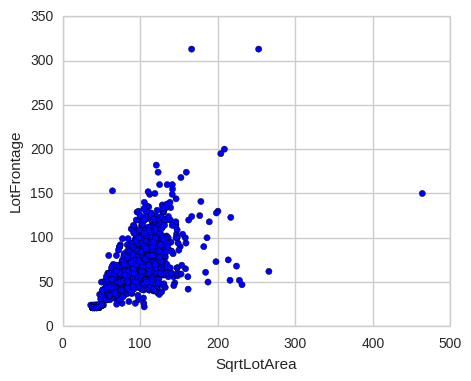

In [287]:
# 绘制 LotFrontage 与 LotArea 原始数据
lot_datas = conbined_data[['LotFrontage','SqrtLotArea']].dropna()
plt.figure(figsize=(5,4))
plt.scatter(lot_datas['SqrtLotArea'], lot_datas['LotFrontage'])
plt.xlabel("SqrtLotArea") 
plt.ylabel("LotFrontage") 

In [288]:
from sklearn.linear_model import LinearRegression

# Create linear regression object
regr = LinearRegression()

In [289]:
lotFrontage = lot_datas.iloc[:,0].values
sqrtLotArea = lot_datas.iloc[:,1].values

length = lotFrontage.shape[0]
lotFrontage = lotFrontage.reshape(length, 1)
sqrtLotArea = sqrtLotArea.reshape(length, 1)

# Train the model using the training sets
regr.fit(sqrtLotArea, lotFrontage)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [290]:
# The coefficients
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([[ 0.6430147]]))


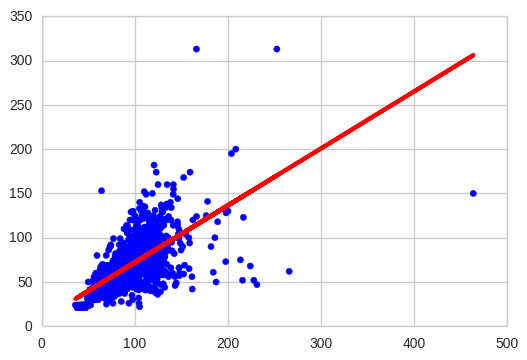

In [291]:
plt.scatter(sqrtLotArea, lotFrontage,  color='blue')
plt.plot(sqrtLotArea, regr.predict(sqrtLotArea), color='red',
         linewidth=3)

In [292]:
def fill_missing_lotfrontage(sqrt_lotarea):
    """
    填充缺失的 LotFrontage 数据
    """
    return 0.6430147 * sqrt_lotarea

column = conbined_data['LotFrontage'].isnull()
conbined_data['LotFrontage'][column] = conbined_data['SqrtLotArea'][column].map(fill_missing_lotfrontage)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [293]:
conbined_data[conbined_data['LotFrontage'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SqrtLotArea


In [294]:
conbined_data.drop('SqrtLotArea', axis=1, inplace=True)
conbined_data.shape

(2919, 80)

** Alley **

In [295]:
conbined_data.shape, conbined_data[conbined_data['Alley'].isnull()].shape

((2919, 80), (2721, 80))

2919 条数据缺失 2721 条，缺失数据过多(93.2%),将缺失数据填充为 NA（NA->No alley access）。

In [296]:
fill_missing_conbined_data('Alley', 'NA')
conbined_data[conbined_data['Alley'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


** MasVnrType / MasVnrArea **

方形单板砌体类型/面积，将缺失数据填充为出现次数最多的类型

In [297]:
conbined_data['MasVnrType'].fillna('None', inplace=True)
conbined_data['MasVnrArea'].fillna(0, inplace=True)

In [298]:
conbined_data['MasVnrType'].isnull().sum(), conbined_data['MasVnrArea'].isnull().sum()

(0, 0)

** BsmtQual / BsmtCond / BsmtExposure / BsmtFinType1 / BsmtFinType2 **

缺失 37 / 38 条数据。

In [299]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

In [300]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Basement
for column in basement_cols:
    if 'FinSF'not in column:
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')

In [301]:
# 对于数值型的 BsmtFinSF1 和 BsmtFinSF2
fill_missing_conbined_data('BsmtFinSF1', 0)
fill_missing_conbined_data('BsmtFinSF2', 0)

In [304]:
conbined_data[basement_cols].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtFinSF1      0
BsmtFinSF2      0
dtype: int64

** Electrical **

缺失一条数据,填充为出现次数最多的。

In [306]:
fill_missing_conbined_data('Electrical', conbined_data['Electrical'].max())

** FireplaceQu **

缺失 1420 条数据
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality

所以 FireplaceQu 与 Fireplaces 有关系

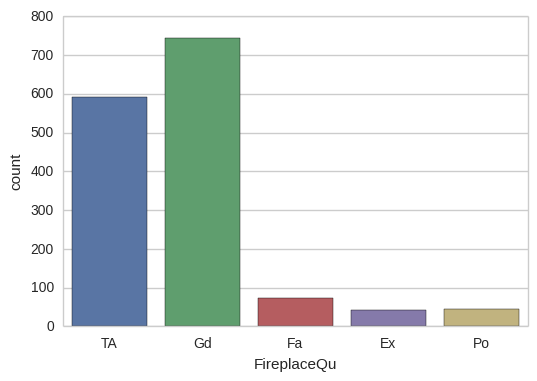

In [325]:
conbined_data['FireplaceQu'].value_counts()
conbined_data[['FireplaceQu', 'Fireplaces']].groupby(['FireplaceQu']).median()
sns.countplot(conbined_data['FireplaceQu'])

In [337]:
# 对于 Fireplaces 为 0 的，FireplaceQu 设置为 NA，表示 No Fireplace，此即缺失的 1420 条数据的情况
fill_missing_conbined_data('FireplaceQu', 'NA')

** PoolQC **

PoolQC 缺失 2909 条数据，是否与 PoolArea 有关。

In [343]:
fill_missing_conbined_data('PoolQC', 'NA')

** MiscFeature **

In [345]:
fill_missing_conbined_data('MiscFeature', 'NA')

** Fence **

In [348]:
fill_missing_conbined_data('Fence', 'NA')

** Garages **

In [354]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
conbined_data[garage_cols][conbined_data['GarageType'].isnull()==True].head(1)

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [357]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Garage
for column in garage_cols:
    if column != 'GarageCars' and column != 'GarageArea':
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')
    else:
        fill_missing_conbined_data(column, 0)

** MSZoning **

** Utilities **

** Exterior1st **

In [356]:
# 存在缺失数据的列名
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# 每列包含多少缺失数据
conbined_data[has_null_columns].isnull().sum()

MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
SaleType        1
dtype: int64

In [5]:
# dtypes: float64(3), int64(35), object(43)
# 可以看出训练集有 38 列数值型数据，43 列字符串类型的数据
train_data.describe()

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,NaN,7553.500000,5.000000,5.000000,1954.000000,1967.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,NaN,9478.500000,6.000000,5.000000,1973.000000,1994.000000,NaN,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,NaN,11601.500000,7.000000,6.000000,2000.000000,2004.000000,NaN,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
# preprocessing.LabelEncoder: Encode labels with value between 0 and n_classes-1.
from sklearn import preprocessing

# 包含43列字符串类型的数据
train_str = train_data.select_dtypes(include=['object'])
test_str = test_data.select_dtypes(include=['object'])

# train_str.columns.values 获取列名称，返回array类型
column_names = train_str.columns.values
print column_names
train_data.drop(column_names, axis=1, inplace=True)
test_data.drop(column_names, axis=1, inplace=True)

print train_data.shape, test_data.shape

['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC'
 'CentralAir' 'Electrical' 'KitchenQual' 'Functional' 'FireplaceQu'
 'GarageType' 'GarageFinish' 'GarageQual' 'GarageCond' 'PavedDrive'
 'PoolQC' 'Fence' 'MiscFeature' 'SaleType' 'SaleCondition']
(1460, 38) (1459, 37)


In [6]:
train_str_dummies = pd.get_dummies(train_str)
test_str_dummies = pd.get_dummies(test_str)

# 选择训练集和测试集都有的列
columns_dum = list(set(train_str_dummies) & set(test_str_dummies))

train_str_dummies = train_str_dummies[columns_dum]
test_str_dummies = test_str_dummies[columns_dum]

train_data_new = pd.merge(train_data,train_str_dummies,left_index=True,right_index=True)
test_data_new = pd.merge(test_data,test_str_dummies,left_index=True,right_index=True)

print train_data_new.shape, test_data_new.shape

(1460, 287) (1459, 286)


(array([   5.,   12.,   54.,  184.,  470.,  400.,  220.,   90.,   19.,    6.]),
 array([ 10.46024211,  10.7676652 ,  11.07508829,  11.38251138,
         11.68993448,  11.99735757,  12.30478066,  12.61220375,
         12.91962684,  13.22704994,  13.53447303]),
 <a list of 10 Patch objects>)

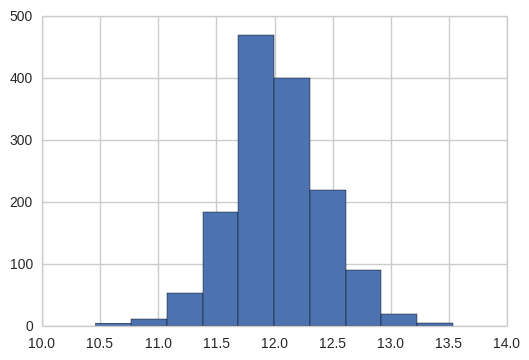

In [7]:
# 价格分布
plt.hist(np.log(train_data.SalePrice))

In [8]:
train_Y = train_data_new.SalePrice
train_X = train_data_new.drop(['Id', 'SalePrice'], axis=1)
test_X = test_data_new.drop(['Id'], axis=1)
test_Id = test_data_new.Id

del train_data
del train_data_new
del test_data_new

print train_X.shape, train_Y.shape, test_X.shape

(1460, 285) (1460,) (1459, 285)


In [9]:
train_X.head(1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Neighborhood_SawyerW,KitchenQual_Fa,RoofStyle_Hip,Functional_Maj1,GarageType_Detchd,Fence_GdWo,LotShape_IR1,LotShape_IR2,LotShape_IR3,SaleCondition_Alloca
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=100)
clf.fit(train_X, train_Y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = train_X.columns
feature_importance['importance'] = clf.feature_importances_

feature_importance.sort_values(by=['importance'], ascending=False)

,feature,importance
15,GrLivArea,0.020776
2,LotArea,0.020365
12,1stFlrSF,0.020296
34,MoSold,0.019982
10,BsmtUnfSF,0.019815
26,GarageArea,0.019391
1,LotFrontage,0.019310
11,TotalBsmtSF,0.019307
35,YrSold,0.018732
5,YearBuilt,0.018466


In [13]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=300)

forest.fit(train_X, train_Y)

forest_predictions = forest.predict(test_X).astype(int)
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": forest_predictions
    })

submission.to_csv("result/simple_RF_predictions_2_1.csv", index=False)

print "RandomForestClassifier Done."

RandomForestClassifier Done.
